# Face Mask Detection

**A Project by:**
* Wei Ming Chun 97231162
* Chou Cheng-Ting 97231013-5
* Ma Sungbin 1M190219-2
* Mikhail Paglinawan 1M211125-5
* Zhu Tianheng 1M201116

## Introduction

The Face Mask Detection AI Project represents a significant advance in the field of public health technology, particularly in the context of the recent COVID-19 pandemic. This project employs a dataset comprising approximately 12,000 images, meticulously curated to include an equal distribution of masked and unmasked faces. The dataset, derived from sources such as Google searches and the CelebFace dataset by Jessica Li, offers a comprehensive basis for the development of sophisticated artificial intelligence models. This initiative is not only timely, given the recent global health crisis, but also forward-looking, as it addresses a crucial aspect of health safety measures in public settings. The project underscores the potential of AI in enhancing public health monitoring and compliance, especially in environments where manual enforcement is challenging.

## Motivation

The Face Mask Detection AI Project was conceived in response to the unprecedented challenges posed by the COVID-19 pandemic, particularly the enforcement of mask-wearing mandates in public spaces. While the acute phase of the pandemic has subsided, the relevance of such technologies persists, especially in preparing for potential future health crises. The project is motivated by the objective to utilize artificial intelligence for the real-time and accurate detection of mask usage, facilitating the enforcement of health guidelines in various settings. Beyond its immediate application during the pandemic, the project envisions a broader scope, including applications in public health surveillance and safety protocol enforcement. This endeavor aims to demonstrate the efficacy of AI in public health initiatives, offering insights into its potential role in future societal challenges. The project's foundation in AI technology not only addresses immediate needs but also contributes to the evolving landscape of public health technology.

## Techniques & Background

The Face Mask Detection AI Project employs an array of  machine learning techniques, each offering unique perspectives and strengths in the realm of image analysis. This multi-faceted approach not only underscores the versatility of machine learning in practical applications but also provides a comprehensive understanding of how different models perform in the context of face mask detection. The methodologies employed in this project are as follows:

- Baseline: Majority - This approach establishes a baseline for comparison by predicting the majority class for every instance. It serves as a rudimentary benchmark, allowing us to gauge the effectiveness of more sophisticated models.

- Logistic Regression with SIFT - Scale-Invariant Feature Transform (SIFT) is integrated with Logistic Regression to create a model that combines traditional machine learning with advanced feature extraction techniques. SIFT identifies key features in images, which are then fed into the Logistic Regression model to classify whether a face mask is present or not.

- SIFT MLP (Multilayer Perceptron) - Building upon the SIFT features, this model leverages a Multilayer Perceptron, a type of neural network, to process the extracted features. This combination aims to enhance the model's ability to learn complex patterns from the SIFT-identified key points.

- Flattened MLP - This model directly processes flattened image data using a Multilayer Perceptron. By bypassing feature extraction steps like SIFT, it tests the MLP's capability to discern patterns and classify images based on raw pixel data.

- CNN (Convolutional Neural Network) - As a state-of-the-art approach in image recognition, CNNs are expected to excel in this application. These networks are inherently designed for image analysis, capable of automatically and efficiently identifying critical features in images for classification tasks.

In comparing these models, accuracy serves as the primary metric, providing a clear and quantifiable measure of each model's performance in correctly identifying the presence or absence of face masks in images. Given the sophistication and specialized nature of CNNs in handling image data, it is anticipated that the CNN model will outperform the other techniques, affirming its status as a powerful tool in image classification and its suitability for applications in public health monitoring and safety compliance.

## Data Source & Description

https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

## Data Analysis & Modeling

### Preliminary Kaggle Setup

In [ ]:
## Kaggle setup. Need your json api key
from google.colab import files
! pip install -q kaggle
files.upload()

In [ ]:
## Install and handle downloading/unzipping dataset
%%capture
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
! mkdir train
! unzip face-mask-12k-images-dataset.zip -d train

### Imports

In [ ]:
%%capture

# array & math manipulation
import math
import numpy as np
import random

# image & dataset handling
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Machine learning
! pip install d2l==1.0.3
import torch
import torchvision
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### EDA

Let's load the dataset. The dataset we have provides data for training and validation. Since we are doing cross validation, we merge them together and split randomly later instead.

In [ ]:
def loadDataSet(p):
  image_paths = [(path.parts[-2], p + "/" + path.parts[-1]) for path in Path(p).rglob('*.*')]
  return pd.DataFrame(data=image_paths, columns=['Class','Path'])

df_train_w   = loadDataSet("./train/Face Mask Dataset/Train/WithMask")
df_train_wo  = loadDataSet("./train/Face Mask Dataset/Train/WithoutMask")
df_valid_w   = loadDataSet("./train/Face Mask Dataset/Validation/WithMask")
df_valid_wo  = loadDataSet("./train/Face Mask Dataset/Validation/WithoutMask")

# We'll combine "train" and "validation" images and do our own splitting instead
df_train = pd.concat([df_train_w, df_train_wo, df_valid_w, df_valid_wo])

# change WithMask/WithoutMask to 1/0 encoding
df_train['Class'] = (df_train['Class'] == "WithMask").astype(int)

print(len(df_train), "total pictures.")
print(len(df_train[df_train['Class'] == 1]), "pictures of mask on in training dataset.")
print(len(df_train[df_train['Class'] == 0]), "pictures of mask off in training dataset.")

#read all images through image paths stored in df_train
#and store them as 3d vectors of height, width, color(3 channels: RGB)
images_train = [cv2.imread(path) for path in df_train['Path']]

#store the 3d vectors back into the dataframe
df_train['image_data'] = images_train

df_train.head(3)

10800 total pictures.
5400 pictures of mask on in training dataset.
5400 pictures of mask off in training dataset.


,Class,Path,image_data
0,1,./train/Face Mask Dataset/Train/WithMask/Augme...,"[[[201, 214, 214], [201, 214, 214], [201, 214,..."
1,1,./train/Face Mask Dataset/Train/WithMask/Augme...,"[[[175, 211, 219], [167, 202, 211], [158, 193,..."
2,1,./train/Face Mask Dataset/Train/WithMask/Augme...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


#### Image Dimension Analysis

Let's take a look at the dimensions of the images




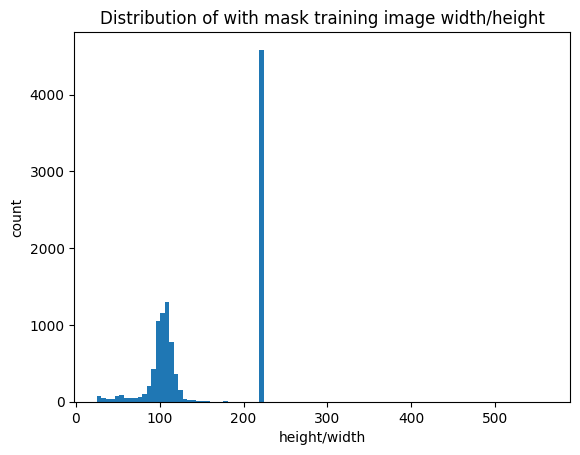

Measures of Image Distribution for training set with mask
Minimum = 25
Maximum = 563
Range = 538
Variance = 3959.987620361797
Standard Deviation = 62.92843252744976


In [ ]:
#Retrieve the dimension of every image to do further analysis
images_train_dim = [image.shape[0] for image in images_train]

#distribution of the image sizes
images_train_dim_min = np.amin(images_train_dim)
images_train_dim_max = np.amax(images_train_dim)
images_train_dim_range = np.ptp(images_train_dim)
images_train_dim_variance = np.var(images_train_dim)
images_train_dim_sd = np.std(images_train_dim)

plt.hist(images_train_dim, bins=100)
plt.title("Distribution of with mask training image width/height")
plt.xlabel("height/width")
plt.ylabel("count")
plt.show()

print("Measures of Image Distribution for training set with mask")
print("Minimum =", images_train_dim_min)
print("Maximum =", images_train_dim_max)
print("Range =", images_train_dim_range)
print("Variance =", images_train_dim_variance)
print("Standard Deviation =", images_train_dim_sd)

The images are of different sizes. We need to standardize size for our purpose. We will aim to resize to 64 x 64 in this project due to computational limits and the nature of the dataset containing low resolution images. For upsizing images, we use a simple approach, INTER_NEAREST, which finds the “nearest” neighboring pixel and assumes the intensity value.

In [ ]:
class Rescale(object):
  """Rescale the image in a sample to a given size."""
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, img):
    # all images are square, check if height is equal to output size if not then resize
    if(img.shape[0] != self.output_size):
      img = cv2.resize(img, (self.output_size, self.output_size),interpolation=cv2.INTER_NEAREST)
    return img

RESCALE = Rescale(64)
df_train['image_data'] = [RESCALE(img) for img in df_train['image_data']]

#### Remove misclassified images in dataset

There are some misclassified images in the dataset, let's remove those images.

In [ ]:
#Misclassified images are identified by our own
misclassified_imgs = ['./train/Face Mask Dataset/Train/WithMask/Augmented_509_362037.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_11_1899363.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_13_84296.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_51_2875928.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_66_8316031.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_104_4420306.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_521_4838931.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_163_4056851.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_136_24781.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_189_9029127.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_227_9343626.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_524_4426698.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_250_9824157.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_292_6710394.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_708_8968262.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_365_4420617.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_850_3844813.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_376_1988390.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_382_6451781.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_447_2254022.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_448_586641.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_483_1068482.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_518_6531533.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_559_9715515.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_659_8187931.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_723_1998631.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_739_2921086.png',
                          './train/Face Mask Dataset/Train/WithMask/Augmented_887_9435344.png',
                          './train/Face Mask Dataset/Validation/WithMask/Augmented_222_6307549.png',
                          './train/Face Mask Dataset/Validation/WithMask/Augmented_114_3364673.png',
                          './train/Face Mask Dataset/Validation/WithMask/Augmented_827_1110266.png',
                          './train/Face Mask Dataset/Validation/WithMask/Augmented_890_2093095.png',
                          ]

df_removed = df_train[df_train['Path'].isin(misclassified_imgs)]
df_train = df_train[~df_train['Path'].isin(misclassified_imgs)]

#Misclassfied images are stored in df_removed and 5 random examples are shown
if(len(df_removed) > 0):
  sample = random.sample(range(len(df_removed)), 5)
  example_imgs = df_removed["image_data"].iloc[sample].tolist()
  cv2_imshow(cv2.hconcat(example_imgs))

#### Image Visualization

In general, it is a good idea to visualize and inspect data that you're training on.
Humans are very good at spotting unusual aspects and as such, visualization serves as an additional safeguard against mistakes and errors in the design of experiments.

Let's take a look at some example images in our dataset

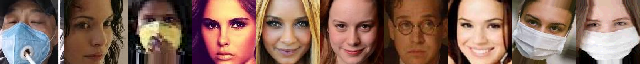

In [ ]:
sample = random.sample(range(len(df_train["Path"])), 10)
example_imgs = df_train["image_data"].iloc[sample].tolist()
cv2_imshow(cv2.hconcat(example_imgs))

We'll be using SIFT to extract keypoints out of the images to create a BOW.
Then, using the BOW, we create a feature vector for each image.

The process is as follows
1.   Rescale
2.   Convert image to grayscale and extract SIFT Keypoints and Descriptors
3.   Build Bag of words dictionary using SIFT descriptors from training images by using Kmeans
4.   Using the trained Bag of words as features for each image for MLP


A simple explanation of SIFT BOW is below.
https://customers.pyimagesearch.com/the-bag-of-visual-words-model/#:~:text=Simply%20put%2C%20the%20bag%20of,histogram%20based%20on%20our%20dictionary.

In [ ]:
class ToSIFT(object):
  def __init__(self, extractor):
    self.sift = extractor

  """Convert the image in a sample to sift features."""
  def __call__(self, img):
    gray_scale= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = self.sift.detectAndCompute(gray_scale, None)
    return gray_scale, kp, des, img

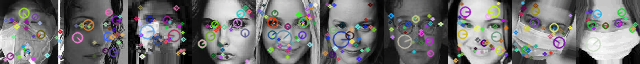

In [ ]:
# Example SIFT Feature
sift_transform = ToSIFT(cv2.SIFT_create())
extracted_imgs = [sift_transform(img) for img in example_imgs]

sift_imgs = [cv2.drawKeypoints(s_img[0], s_img[1], s_img[3], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) for s_img in extracted_imgs]
cv2_imshow(cv2.hconcat(sift_imgs))

In [ ]:
# Dataset Class for handling Image to BOW SIFT
class MaskSIFTData(d2l.DataModule):
  """Synthetic data for linear regression."""
  def __init__(self, data, train_size=0.8, batch_size=32, num_inputs=64):
    super().__init__()
    self.save_hyperparameters()
    self.num_train = math.floor(len(self.data) * train_size)

    # shuffle before splitting
    self.data = data.to_numpy()
    np.random.shuffle(self.data)

    # convert images to grayscale, kp, and descriptor
    self.sift_extractor = cv2.SIFT_create()
    self.sift_images = self.extract_SIFT(self.data[:, 2], ToSIFT(self.sift_extractor))

    # Train SIFT BOW dictionary using training set only
    self.img_extractor = cv2.BOWImgDescriptorExtractor(self.sift_extractor, cv2.BFMatcher(cv2.NORM_L2))
    self.img_extractor.setVocabulary(self.train_SIFT(self.sift_images[:self.num_train]))

    # Convert all images to visual vector
    self.x_all = np.array([self.compute_BOW(img) for img in self.sift_images])
    self.y_all = self.data[:, 0].astype(int)

    # Split to train and validation set
    self.x_train = self.x_all[:self.num_train]
    self.x_valid = self.x_all[self.num_train:]
    self.y_train = self.y_all[:self.num_train]
    self.y_valid = self.y_all[self.num_train:]

  def get_dataloader(self, train):
    if(train):
      return self.get_imageloader((self.x_train, self.y_train), True)
    else:
      return self.get_imageloader((self.x_valid, self.y_valid), False)

  def train_dataloader(self):
    return self.get_dataloader(train=True)

  def val_dataloader(self):
    return self.get_dataloader(train=False)

  def get_imageloader(self, tensors, train):
    """Defined in :numref:`sec_synthetic-regression-data`"""
    dataset = torch.utils.data.TensorDataset(torch.tensor(tensors[0]), torch.tensor(tensors[1]))
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

  def train_SIFT(self, train_data):
    BOW = cv2.BOWKMeansTrainer(self.num_inputs)
    for row in train_data:
      if(row[2] is None):
        BOW.add(np.zeros((1, 128), np.float32)) # no descriptors found
      else:
        BOW.add(row[2])
    return BOW.cluster()

  def get_train_data(self):
    return (self.x_train, self.y_train)

  def get_valid_data(self):
    return (self.x_valid, self.y_valid)

  def get_all_data(self):
    return (self.x_all, self.y_all)

  def compute_BOW(self, img):
    if(img[2] is None):
      return np.zeros(self.num_inputs, np.float32)
    else:
      return self.img_extractor.compute(img[0], img[1], img[2])[0]

  def extract_SIFT(self, imgs, compose):
     res = []
     for idx, img in enumerate(imgs):
      if((idx > 0 and (idx + 1) % 1000 == 0) or idx == len(imgs) - 1):
        print(f'Processed image: {idx + 1}')
      res.append(compose(img))
     return np.array(res, dtype=object)

  def convert_test_data(self, imgs):
    sift_images = self.extract_SIFT(imgs, ToSIFT(self.sift_extractor))
    return np.array([self.compute_BOW(img) for img in sift_images])


NUM_SIFT_FEATURES = 16
siftData = MaskSIFTData(df_train, num_inputs=NUM_SIFT_FEATURES)

Processed image: 1000
Processed image: 2000
Processed image: 3000
Processed image: 4000
Processed image: 5000
Processed image: 6000
Processed image: 7000
Processed image: 8000
Processed image: 9000
Processed image: 10000
Processed image: 10768


## Machine Learning Models

### Baseline Model: Majority

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(siftData.get_train_data()[0], siftData.get_train_data()[1])

print('Baseline accuracy (training): ', dummy.score(siftData.get_train_data()[0], siftData.get_train_data()[1]))
print('Baseline accuracy (validation): ', dummy.score(siftData.get_valid_data()[0], siftData.get_valid_data()[1]))

Baseline accuracy (training):  0.5023218017181332
Baseline accuracy (validation):  0.4832869080779944


### SIFT Based Models

#### Logistic Regression

In [ ]:
param_grid = {"C": np.logspace(-3, 3, 10)}
lr = LogisticRegression(random_state=123, max_iter=2000)

x = siftData.get_train_data()[0]
y = siftData.get_train_data()[1]

# Cross validation to pick best regularization strength
lr_cv = GridSearchCV(lr, param_grid, cv=5).fit(x, y)

print('Validation Accuracy: ', lr_cv.best_score_)
print(f'Best regularization strength: {lr_cv.best_params_}')

Validation Accuracy:  0.6382643648175972
Best regularization strength: {'C': 10.0}


#### Deep SIFT MLP Model

In [ ]:
# Model
class SiftMLP(d2l.Classifier):
  def __init__(self, num_inputs, num_outputs, lr, hidden_dims=[], activation=nn.ReLU, dropout_p=0):
    super().__init__()
    self.save_hyperparameters()
    layers = []
    for d in hidden_dims:
      layers.append(nn.LazyLinear(d))
      layers.append(activation())
      layers.append(nn.Dropout(dropout_p))

    layers.append(nn.LazyLinear(num_outputs))
    self.net = nn.Sequential(*layers)

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
    y = y.reshape((-1,))
    return nn.functional.cross_entropy(y_hat, y, reduction='mean')

##### HyperParameters tuning

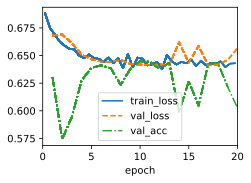

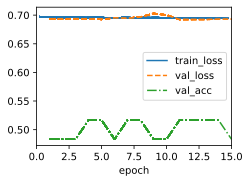

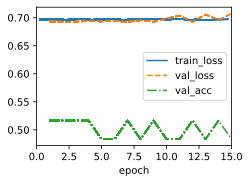

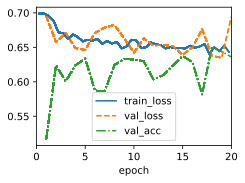

In [ ]:
mlp_params = {
    'dims': [[], [16, 8], [8, 4], [64, 32, 16]],
    'act': [nn.ReLU, nn.Sigmoid, nn.ReLU, nn.ReLU],
    'batch': [1, 1, 1, 1],
    'epoch': [20, 15, 15, 20],
    'dropout_p': [0, 0.01, 0.05, 0.03],
    'lr': [0.02, 0.01, 0.03, 0.04]
}


mlp_accuracies = []
mlp_models = []

for i in range(len(mlp_params['lr'])):
  model = SiftMLP(num_inputs=NUM_SIFT_FEATURES,
                                   num_outputs=2,
                                   lr=mlp_params['lr'][i],
                                   hidden_dims=mlp_params['dims'][i],
                                   activation=mlp_params['act'][i],
                                   dropout_p=mlp_params['dropout_p'][i])
  siftData.batch_size = mlp_params['batch'][i]
  trainer = d2l.Trainer(max_epochs=mlp_params['epoch'][i])
  trainer.fit(model, siftData)

  X = torch.tensor(siftData.get_train_data()[0])
  Y = torch.tensor(siftData.get_train_data()[1])
  X_VALID = torch.tensor(siftData.get_valid_data()[0])
  Y_VALID = torch.tensor(siftData.get_valid_data()[1])

  mlp_models.append(model)
  accuracy = [model.accuracy(model(X), Y).item(), model.accuracy(model(X_VALID), Y_VALID).item()]
  mlp_accuracies.append(accuracy)

In [ ]:
print("Accuracies: ", mlp_accuracies)

# Best MLP
best_mlp_idx = np.argmax([m[1] for m in mlp_accuracies])

best_mlp = {'model': mlp_models[best_mlp_idx],
            'accuracy': mlp_accuracies[best_mlp_idx]}

Accuracies:  [[0.6208497881889343, 0.6025997996330261], [0.5023217797279358, 0.48328691720962524], [0.5023217797279358, 0.48328691720962524], [0.627699077129364, 0.6360260248184204]]


### Pixel Based Models

#### Data Module

In [ ]:
# Dataset Class for handling Image to feed into CNN
class NNData(d2l.DataModule):
  def __init__(self, data, train_size=0.8, batch_size=64, resize=(28, 28)):
      super().__init__()
      self.save_hyperparameters()
      self.num_train = math.floor(len(self.data) * train_size)

      #transform img vectors to tensors
      compose = transforms.ToTensor()
      self.x_all = np.array([compose(img) for img in data['image_data']])
      self.y_all = np.array(data['Class'].tolist())

      p = np.random.permutation(len(self.x_all))
      self.x_all = self.x_all[p]
      self.y_all = self.y_all[p]

      #divide dataset to training and validation
      self.x_train = self.x_all[:self.num_train]
      self.y_train = self.y_all[:self.num_train]
      self.x_valid = self.x_all[self.num_train:]
      self.y_valid = self.y_all[self.num_train:]

  def get_dataloader(self, train):
    if(train):
      return self.get_imageloader((self.x_train, self.y_train), True)
    else:
      return self.get_imageloader((self.x_valid, self.y_valid), False)

  def train_dataloader(self):
    return self.get_dataloader(train=True)

  def val_dataloader(self):
    return self.get_dataloader(train=False)

  def get_train_data(self):
    return (self.x_train, self.y_train)

  def get_valid_data(self):
    return (self.x_valid, self.y_valid)

  def get_imageloader(self, tensors, train):
    dataset = torch.utils.data.TensorDataset(torch.stack(tuple(tensors[0].tolist())), torch.tensor(tensors[1]))
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

#### Flattened Deep MLP

##### Model

In [ ]:
class FlattenMLP(d2l.Classifier):
  def __init__(self, num_inputs, num_outputs, lr, hidden_dims=[], activation=nn.ReLU, dropout_p=0):
    super().__init__()
    self.save_hyperparameters()
    layers = [nn.Flatten()]
    for d in hidden_dims:
      layers.append(nn.LazyLinear(d))
      layers.append(activation())
      layers.append(nn.Dropout(dropout_p))

    layers.append(nn.LazyLinear(num_outputs))
    self.net = nn.Sequential(*layers)

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
    y = y.reshape((-1,))
    return nn.functional.cross_entropy(y_hat, y, reduction='mean')

##### Hyper Parameter Experimenting

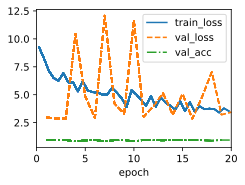

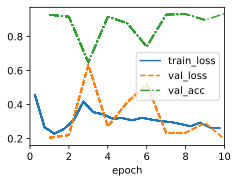

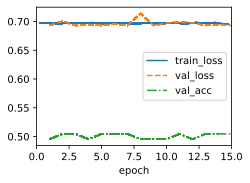

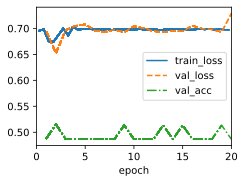

In [ ]:
fmlp_params = {
    'dims': [[], [16, 8], [8, 4], [64, 32, 16]],
    'act': [nn.ReLU, nn.Sigmoid, nn.ReLU, nn.ReLU],
    'batch': [1, 1, 1, 1],
    'epoch': [20, 10, 15, 20],
    'dropout_p': [0, 0.01, 0.05, 0.03],
    'lr': [0.02, 0.01, 0.03, 0.04]
}


fmlp_accuracies = []
fmlp_models = []

for i in range(len(fmlp_params['lr'])):
  model = FlattenMLP(num_inputs=NUM_SIFT_FEATURES,
                                   num_outputs=2,
                                   lr=fmlp_params['lr'][i],
                                   hidden_dims=fmlp_params['dims'][i],
                                   activation=fmlp_params['act'][i],
                                   dropout_p=fmlp_params['dropout_p'][i])
  data = NNData(df_train, batch_size=fmlp_params['batch'][i])
  trainer = d2l.Trainer(max_epochs=fmlp_params['epoch'][i])
  trainer.fit(model, data)

  X = torch.stack(tuple(data.get_train_data()[0].tolist()))
  Y = torch.tensor(data.get_train_data()[1])
  X_VALID = torch.stack(tuple(data.get_valid_data()[0].tolist()))
  Y_VALID = torch.tensor(data.get_valid_data()[1])

  fmlp_models.append(model)
  accuracy = [model.accuracy(model(X), Y).item(), model.accuracy(model(X_VALID), Y_VALID).item()]
  fmlp_accuracies.append(accuracy)

In [ ]:
print("Accuracies: ", fmlp_accuracies)

# Best FMLP
best_fmlp_idx = np.argmax([m[1] for m in fmlp_accuracies])

best_fmlp = {'model': fmlp_models[best_fmlp_idx],
            'accuracy': fmlp_accuracies[best_fmlp_idx]}

Accuracies:  [[0.9579753875732422, 0.9345403909683228], [0.935802161693573, 0.9345403909683228], [0.5006965398788452, 0.5046425461769104], [0.5052240490913391, 0.4865366816520691]]


#### CNN LENET

##### model

We utilized the LeNet structure (Introduced by Yann LeCun) for our CNN model while tweaking some parameters.

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, params, lr=0.1, num_classes=2):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Conv2d(3, params['conv_1_filters'],
                      kernel_size=params['conv_1_kernel'],
                      padding=params['conv_1_padding']),
            params['act'](),
            params['pool_1'],
            nn.Conv2d(6, params['conv_2_filters'],
                      kernel_size=params['conv_2_kernel']),
            params['act'](),
            params['pool_2'],
            nn.Flatten(),
            nn.LazyLinear(120), params['act'](),
            nn.LazyLinear(84), params['act'](),
            nn.LazyLinear(num_classes))

@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

##### HyperParameters Experimenting

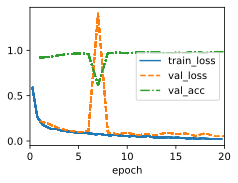

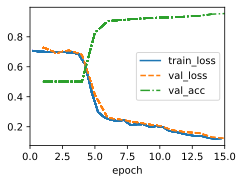

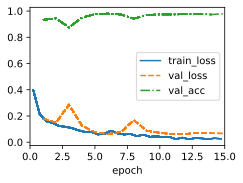

In [ ]:
cnn_params = [{
    'act': nn.ReLU,
    'conv_1_filters': 6,
    'conv_1_padding': 2,
    'conv_1_kernel': 3,
    'conv_2_filters': 16,
    'conv_2_kernel': 3,
    'epoch': 20,
    'pool_1': nn.AvgPool2d(kernel_size=2, stride=2),
    'pool_2': nn.AvgPool2d(kernel_size=2, stride=2),
    'lr': 0.01,
    'batch': 16
},{
    'act': nn.Sigmoid,
    'conv_1_filters': 6,
    'conv_1_padding': 3,
    'conv_1_kernel': 2,
    'conv_2_kernel': 3,
    'conv_2_filters': 6,
    'epoch': 15,
    'pool_1': nn.AvgPool2d(kernel_size=3, stride=1),
    'pool_2': nn.AvgPool2d(kernel_size=3, stride=1),
    'lr': 0.03,
    'batch': 16
},{
    'act': nn.ReLU,
    'conv_1_filters': 6,
    'conv_1_padding': 1,
    'conv_1_kernel': 1,
    'conv_2_kernel': 1,
    'conv_2_filters': 6,
    'epoch': 15,
    'pool_1': nn.MaxPool2d(kernel_size=2, stride=2),
    'pool_2': nn.MaxPool2d(kernel_size=2, stride=2),
    'lr': 0.05,
    'batch': 16
}]


cnn_accuracies = []
cnn_models = []

for p in cnn_params:
  data = NNData(df_train, batch_size=p['batch'])
  model = LeNet(p, lr=p['lr'])
  model.apply_init(([next(iter(data.get_dataloader(True)))[0]]), init_cnn)
  trainer = d2l.Trainer(max_epochs=p['epoch'], num_gpus=1)
  trainer.fit(model, data)

  X = torch.stack(tuple(data.get_train_data()[0].tolist()))
  Y = torch.tensor(data.get_train_data()[1])
  X_VALID = torch.stack(tuple(data.get_valid_data()[0].tolist()))
  Y_VALID = torch.tensor(data.get_valid_data()[1])

  cnn_models.append(model)
  accuracy = [model.accuracy(model(X), Y).item(), model.accuracy(model(X_VALID), Y_VALID).item()]
  cnn_accuracies.append(accuracy)
  print("Training accuracy: ", accuracy[0])
  print("Validation accuracy: ", accuracy[1])

In [ ]:
print(cnn_accuracies)

# Best CNN
best_cnn_idx = np.argmax([m[1] for m in cnn_accuracies])
best_cnn = {'model': cnn_models[best_cnn_idx],
            'params': cnn_params[best_cnn_idx],
            'accuracy': cnn_accuracies[best_cnn_idx]}

[[0.9980264902114868, 0.9837511777877808], [0.9207104444503784, 0.9215413331985474], [0.996981680393219, 0.9842154383659363]]


## Final Results & Comparison

Based on our training and validation scores, it seems like CNN will perform the best with logistic regression and deep mlp performing similarly. All of our models perform above the baseline of predicting the majority (random guessing).

In [ ]:
# Load test data
df_test_w = loadDataSet("./train/Face Mask Dataset/Test/WithMask")
df_test_wo = loadDataSet("./train/Face Mask Dataset/Test/WithoutMask")

df_test = pd.concat([df_test_w, df_test_wo])
df_test['Class'] = (df_test['Class'] == "WithMask").astype(int)

rescale_image = Rescale(64)
images_test = [rescale_image(cv2.imread(path)) for path in df_test['Path']]
df_test['image_data'] = images_test

# Use our trained sift data module to convert test_data to BOW
test_sift_data = siftData.convert_test_data(df_test['image_data'])

# See Dummy test set results
print('Dummy Classifier Accuracy: ', dummy.score(test_sift_data, df_test['Class'].tolist()))

Processed image: 992
Dummy Classifier Accuracy:  0.5131048387096774


In [ ]:
def display_predictions(y, y_hat):
  correct = np.random.choice(np.nonzero(y == y_hat)[0], 6, replace=False)
  incorrect = np.random.choice(np.nonzero(y != y_hat)[0], 6, replace=False)

  test_images = df_test['image_data'].to_numpy()
  print("Incorrect predictions")
  cv2_imshow(cv2.hconcat(test_images[incorrect]))

  print("Correct predictions")
  cv2_imshow(cv2.hconcat(test_images[correct]))

Logistic Regression Accuracy:  0.626008064516129
Incorrect predictions


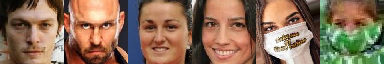

Correct predictions


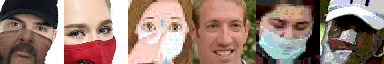

In [ ]:
# Logistic Regression accuracy
ly_hat = lr_cv.predict(test_sift_data)
print('Logistic Regression Accuracy: ', lr_cv.score(test_sift_data, df_test['Class'].tolist()))
display_predictions(df_test['Class'].to_numpy(), ly_hat)

MLP Accuracy tensor(0.6260)
Incorrect predictions


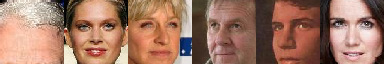

Correct predictions


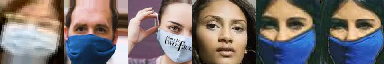

In [ ]:
# MLP accuracy
best_mlp_model = best_mlp['model']
mlp_yhat = best_mlp_model(torch.tensor(test_sift_data))
print('MLP Accuracy', best_mlp_model.accuracy(mlp_yhat, torch.tensor(df_test['Class'].tolist())))
display_predictions(df_test['Class'].to_numpy(), np.argmax(mlp_yhat.detach().numpy(), axis=1))

MLP Accuracy tensor(0.9194)
Incorrect predictions


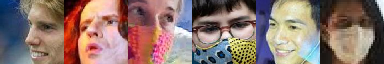

Correct predictions


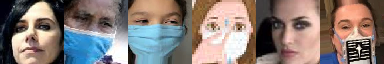

In [ ]:
compose = transforms.ToTensor()
test_nn_data = torch.stack(tuple([compose(img) for img in df_test['image_data']]))

# Flattened MLP accuracy
best_fmlp_model = best_fmlp['model']
fmlp_yhat = best_fmlp_model(test_nn_data)
print('MLP Accuracy', best_fmlp_model.accuracy(fmlp_yhat, torch.tensor(df_test['Class'].tolist())))
display_predictions(df_test['Class'].to_numpy(), np.argmax(fmlp_yhat.detach().numpy(), axis=1))

CNN Accuracy:  tensor(0.9839)
Incorrect predictions


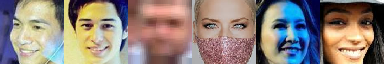

Correct predictions


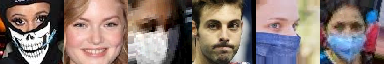

In [ ]:
best_cnn_model = best_cnn['model']
cnn_yhat = best_cnn_model(test_nn_data)
print("CNN Accuracy: ", best_cnn_model.accuracy(cnn_yhat, torch.tensor(df_test['Class'].tolist())))
display_predictions(df_test['Class'].to_numpy(), np.argmax(cnn_yhat.detach().numpy(), axis=1))

As expected in the end, the CNN model performed the best on the test set followed by the Flattend MLP. The SIFT MLP and Logistic regression models performed the worst. All models performed similarly to their validation scores, showing no clear indication of overfitting on the training set.

Examining incorrect predictions by the CNN model, it seems like it had trouble with masks with abnormal patterns or colors similar to skin color and surrounding elements. This is similar with the Flattened MLP model.

Compared to the CNN and Flattened MLP model, both SIFT MLP and Logistic Regression models performed much poorly. It is possible that extracting SIFT features on images of such small size did not work as well as expected as there are a lot of variations in the masks dataset. SIFT did not seem to generalize well for this purpose.

#### Limitations

Due to computational constraints, we had to resize images from the dataset all

1.  **Computational constraints**: We had to resize images from the dataset to 64 x 64 so that we did not run out of RAM while running on colab.
2.   **Dataset**: The size of the data set was relatively small, with only 10768 images.
3.   **Runtime constraints**: We were only able to slightly experiment with hyperparameters for MLP, CNN, and SIFT BOW Extractor due to time constraints.

